In [1]:
import sys
from pathlib import Path

# The orgianl ResNet implementation has in-plance operations which cuase the error during backward pass
# the imported ResNet-from-Scratch has been modified to fix this issue
# e.g. changed self.relu = nn.ReLU to self.relu = nn.ReLU(inplace=False)
# changed x += identity to x = x + identity
sys.path.append(str(Path().resolve() / 'ResNet-from-Scratch'))

In [9]:
# use ResNet-50 model for transfer learning
# using torch for ResNet-50 model as torch is the framework used in the ResNet implementation
import ResNet as rn
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import os
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Define the Dataset and DataLoader
base_dir = os.path.join('datasets', 'cats_and_dogs', 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# transform the image including resize, convert to tensor and normalize
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=validation_dir, transform=transform)

# use DataLoader to load the dataset 
# enable shuffling for training dataset which is to improve the generalization of the model
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


images.shape: torch.Size([3, 299, 299])
labels: 0
images.shape: torch.Size([32, 3, 299, 299])
labels: tensor([0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


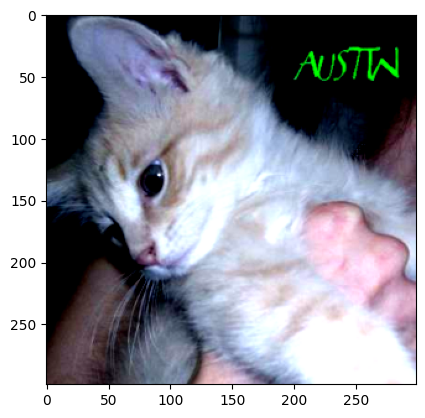

In [11]:
for images, labels in train_dataset:
    print("images.shape:", images.shape)
    print("labels:", labels)
    break


for images, labels in train_loader:
    print("images.shape:", images.shape)
    print("labels:", labels)
    break


def imshow2(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)


# show images
imshow2(images[0])
plt.show()


In [12]:
# using torch for ResNet-50 model as torch is the framework used in the ResNet implementation
import ResNet_PreTrain as rnp

# load the pretrained ResNet-50 model
model = rnp.resnet50(pretrained=True, img_channels=3, num_classes=2)

# freeze all layers
for param in model.parameters():
    param.requires_grad = False

# replace the output layer
num_classes = len(train_dataset.classes)  # Number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

# ensure that the parameters of the new output layer have requires_grad=True
for param in model.fc.parameters():
    param.requires_grad = True

# Move the model to the specified device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only optimize the output layer

# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

# Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f}')

C:\Users\chuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.2376
Validation Accuracy: 0.9860
Epoch 2/10, Loss: 0.0912
Validation Accuracy: 0.9860
Epoch 3/10, Loss: 0.0801
Validation Accuracy: 0.9780
Epoch 4/10, Loss: 0.0666
Validation Accuracy: 0.9850
Epoch 5/10, Loss: 0.0769
Validation Accuracy: 0.9900
Epoch 6/10, Loss: 0.0509
Validation Accuracy: 0.9870
Epoch 7/10, Loss: 0.0452
Validation Accuracy: 0.9890
Epoch 8/10, Loss: 0.0472
Validation Accuracy: 0.9880
Epoch 9/10, Loss: 0.0454
Validation Accuracy: 0.9880
Epoch 10/10, Loss: 0.0458
Validation Accuracy: 0.9880
